In [1]:
import sys
sys.path.append("../dependencies/geometric-algebra-transformer")

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ezgatr.interfaces import point, rotation
from ezgatr.nn.functional import geometric_product, equi_linear
from gatr import GATr, SelfAttentionConfig, MLPConfig
from gatr.primitives import equi_linear as gatr_equi_linear
from gatr.interface import embed_point, extract_point, embed_rotation
from tqdm import tqdm
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.transforms import random_rotation, matrix_to_quaternion
from pytorch3d.loss import chamfer_distance

In [2]:
def plot_pointcloud(points, title=""):
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, y, z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [3]:
# Load the dolphin mesh.
device = "cuda:0"
trg_obj = "dolphin.obj"

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

/home/catcat/projects/img2pc/.venv/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [4]:
mlp = nn.Sequential(
    nn.Linear(3, 256),
    nn.GELU(),
    nn.Linear(256, 256),
    nn.GELU(),
    nn.Linear(256, 3),
).to(device)
mlp.apply(lambda m: nn.init.kaiming_normal_(m.weight, nonlinearity="relu") if isinstance(m, nn.Linear) else None)


optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=3e-4,
    weight_decay=1e-5,
)

In [5]:
model = GATr(
    in_mv_channels=1,
    out_mv_channels=1,
    hidden_mv_channels=16,
    in_s_channels=None,
    out_s_channels=None,
    hidden_s_channels=32,
    num_blocks=16,
    attention=SelfAttentionConfig(),  # Use default parameters for attention
    mlp=MLPConfig(),  # Use default parameters for MLP
).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-5,
)

total_loss = 0.358920:   0%|          | 0/10001 [00:00<?, ?it/s]

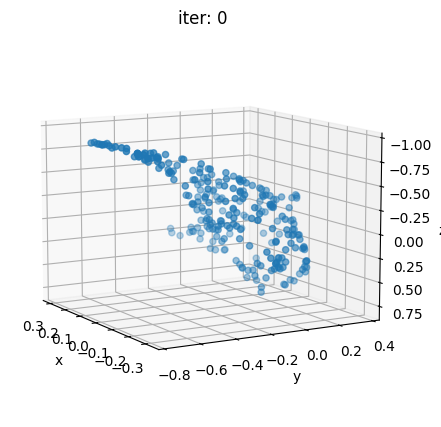

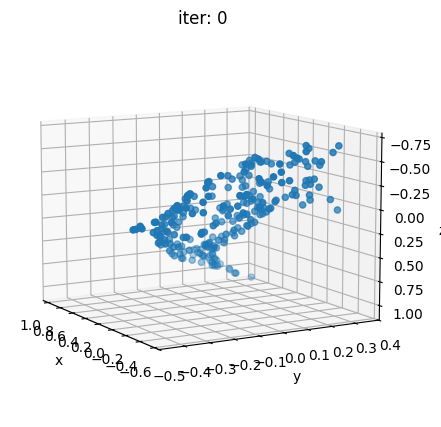

total_loss = 0.127596:  20%|█▉        | 2000/10001 [12:36<52:35,  2.54it/s]  

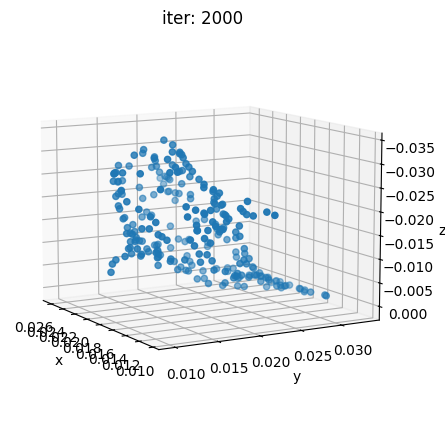

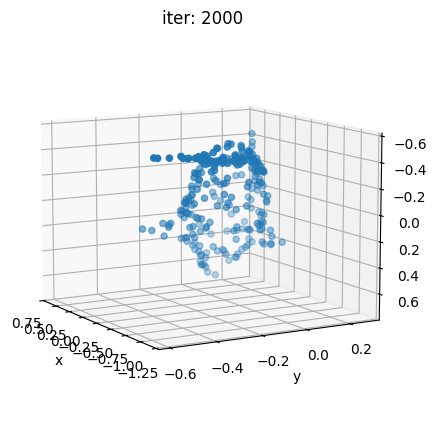

total_loss = 0.119720:  40%|███▉      | 4000/10001 [25:12<40:34,  2.47it/s]  

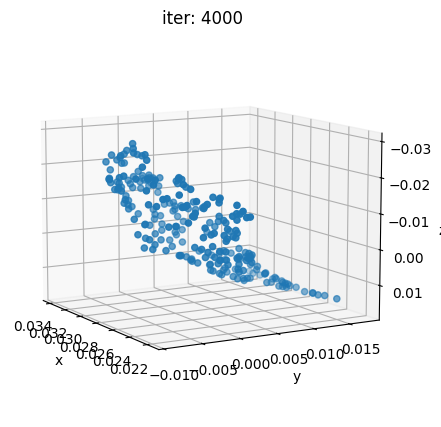

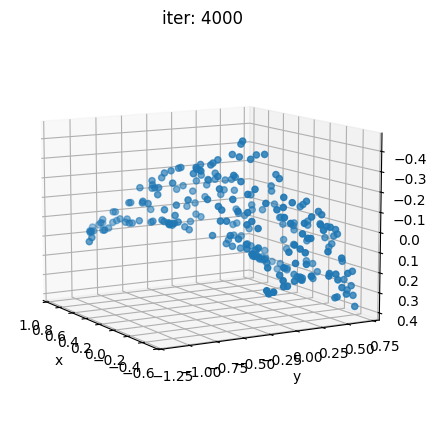

total_loss = 0.118087:  60%|█████▉    | 6000/10001 [37:19<26:01,  2.56it/s]  

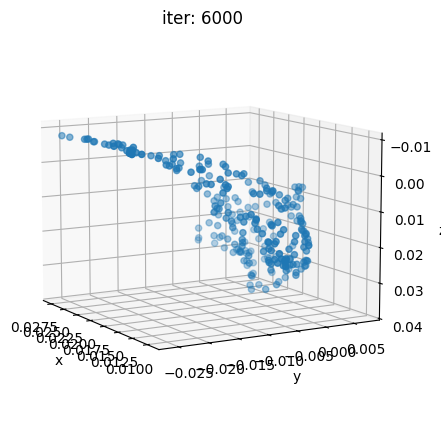

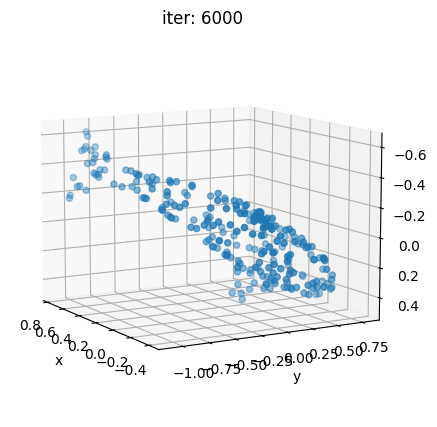

total_loss = 0.110158:  67%|██████▋   | 6746/10001 [41:56<20:14,  2.68it/s]  


KeyboardInterrupt: 

In [6]:
%matplotlib inline

criterion = nn.MSELoss()
losses = []

loop = tqdm(range(10001))
for i in loop:
    r = random_rotation(dtype=torch.float, device=device)
    x = sample_points_from_meshes(trg_mesh, 256)
    y = torch.einsum("bni, ji -> bnj", x.detach(), r) # * 2 + torch.ones_like(x) * 0.1
    # y = sample_points_from_meshes(trg_mesh, 1024)

    x = embed_point(x)
    x[0, 0] = embed_rotation(matrix_to_quaternion(r))
    x = x.unsqueeze(-2)
    p, _ = model(x, scalars=None)
    p = extract_point(p).squeeze(-2)
    # p = mlp(x)

    loss = criterion(p[:, 1:, :], y[:, 1:, :])
    # loss, _ = chamfer_distance(p, y)
    losses.append(float(loss.detach().cpu()))

    loop.set_description('total_loss = %.6f' % loss)
    if i % 2000 == 0:
        plot_pointcloud(p[:, 1:, :], title="iter: %d" % i)
        plot_pointcloud(y[:, 1:, :], title="iter: %d" % i)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()